<a href="https://colab.research.google.com/github/ygeszvain/projects/blob/master/Extracting_Twitter_Data_Avengers_End_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [263]:
!pip install tweepy
!pip install preprocessor

In [264]:
import os
import pandas as pd
import tweepy
import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# importing libraries
from bs4 import BeautifulSoup
import requests
import urllib.request
from urllib.request import urlopen
import re
import time

import pandas as pd #Importing the PANDAS python library
import numpy as np #importing Numpy
%matplotlib inline 

#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #initiating VADER instance

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
#Twitter credentials for the app


In [0]:
#pass twitter credentials to tweepy
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth)

In [0]:
#declare file paths as follows for three files
EndGame_tweets = "EndGame_data.csv"
#epilepsy_tweets = "epilepsy_data.csv"
#heart_stroke_tweets = "heart_stroke_tweets_data.csv"

In [0]:
#columns of the csv file
COLS = ['id', 'created_at', 'source', 'original_text','clean_text', 'sentiment','polarity','subjectivity', 'lang',
        'favorite_count', 'retweet_count', 'original_author', 'possibly_sensitive', 'hashtags',
        'user_mentions', 'place', 'place_coord_boundaries']
 
#set two date variables for date range
start_date = '2019-01-01'
end_date = '2019-05-13'

In [0]:
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [0]:
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [0]:
#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

In [0]:
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [0]:
#mrhod clean_tweets()
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    #Add stop words
    stop_words.add("AvengersEndgame")
    stop_words.add("Avengers")
    stop_words.add("Endgame")
    stop_words.add("Marvel")
    stop_words.add("Studio")
    stop_words.add("Avengersâ")
    word_tokens = word_tokenize(tweet)
 
    #after tweepy preprocessing the colon left remain after removing mentions
    #or RT sign in the beginning of the tweet
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
 
 
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
 
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
 
    #looping through conditions
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)
    #print(word_tokens)
    #print(filtered_sentence)

In [0]:
#method write_tweets()
def write_tweets(keyword, file):
    # If the file exists, then read the existing data from the CSV file.
    if os.path.exists(file):
        df = pd.read_csv(file, header=0)
    else:
        df = pd.DataFrame(columns=COLS)
    #page attribute in tweepy.cursor and iteration
    for page in tweepy.Cursor(api.search, q=keyword,
                              count=200, include_rts=False, since=start_date).pages(50):
        for status in page:
            new_entry = []
            status = status._json
 
            ## check whether the tweet is in english or skip to the next tweet
            if status['lang'] != 'en':
                continue
 
            #when run the code, below code replaces the retweet amount and
            #no of favorires that are changed since last download.
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                if status['favorite_count'] != df.at[i, 'favorite_count'] or \
                   status['retweet_count'] != df.at[i, 'retweet_count']:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue
 
 
           #tweepy preprocessing called for basic preprocessing
            clean_text = status['text']
 
            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(clean_text)
 
            #pass textBlob method for sentiment calculations
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment
 
            #seperate polarity and subjectivity in to two variables
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity
 
            #new entry append
            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'],filtered_tweet, Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]
 
            #to append original author of the tweet
            new_entry.append(status['user']['screen_name'])
 
            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None
            new_entry.append(is_sensitive)
 
            # hashtagas and mentiones are saved using comma separted
            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags)
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions)
 
            #get location of the tweet if possible
            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            new_entry.append(location)
 
            try:
                coordinates = [coord for loc in status['place']['bounding_box']['coordinates'] for coord in loc]
            except TypeError:
                coordinates = None
            new_entry.append(coordinates)
 
            single_tweet_df = pd.DataFrame([new_entry], columns=COLS)
            df = df.append(single_tweet_df, ignore_index=True)
            csvFile = open(file, 'a' ,encoding='utf-8')
    df.to_csv(csvFile, mode='a', columns=COLS, index=False, encoding="utf-8")

In [0]:
#declare keywords as a query for three categories
EndGame_keywords = '#EndGame OR #Avengers OR #AvengersEndGame'
#Epilepsy_keywords = '#Epilepsy OR #epilepsyawareness OR #epilepsyaction OR #epilepsyalerts OR #epilepsybed OR #epilepsycongres OR #epilepsysurgery OR #epilepsysurgery OR #Epilepsytreatment OR #seizures OR #seizurefree'
#HeartDisease_keywords = '#HeartDisease OR #stroke OR #Stroking OR #strokepatient OR #StrokeSurvivor OR #hearthealth OR #Stroke OR #HeartFailure'
 
#call main method passing keywords and file path
write_tweets(EndGame_keywords,  EndGame_tweets)
#write_tweets(Epilepsy_keywords, epilepsy_tweets)
#write_tweets(HeartDisease_keywords, heart_stroke_tweets)

In [0]:
EndGame = pd.read_csv('EndGame_data.csv', sep=',', error_bad_lines=False, encoding = "ISO-8859-1")

In [277]:
EndGame.head()

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,1128071112007405568,Mon May 13 22:54:46 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",The #BlackWidow poster in my room is about to ...,The BlackWidow poster room Endgame ð­ð­ð...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,0,0,SagerDanger,True,"BlackWidow, Endgame, TooSoon, IFixedIt, Marvel",NaN,"Idaho, USA",NaN
1,1128071095712489473,Mon May 13 22:54:42 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @MarkRuffalo: I really think this look work...,RT MarkRuffalo I really think look worked us R...,"Sentiment(polarity=0.24285714285714285, subjec...",0.24285714285714285,0.3678571428571429,en,0,81,RhmSR_,True,"BehindTheScenes, AvengersEndgame","MarkRuffalo, chrishemsworth",NaN,NaN
2,1128071091786854401,Mon May 13 22:54:41 +0000 2019,"<a href=""http://twitter.com/download/android"" ...",RT @9GAG: who lived\n#avengersendgame https://...,RT 9GAG lived avengersendgame https //t.co/ULu...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.0,en,0,503,Niky_ABG,False,avengersendgame,9GAG,"Elche, Alicante, Spain",NaN
3,1128071089509294081,Mon May 13 22:54:40 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",RT @MarkRuffalo: I really think this look work...,RT MarkRuffalo I really think look worked us R...,"Sentiment(polarity=0.24285714285714285, subjec...",0.24285714285714285,0.3678571428571429,en,0,12659,KingEmmaFrost,False,"BehindTheScenes, AvengersEndgame","MarkRuffalo, chrishemsworth",Genosha,NaN
4,1128071079916916736,Mon May 13 22:54:38 +0000 2019,"<a href=""http://twitter.com/download/iphone"" r...",RT @MarkRuffalo: I really think this look work...,RT MarkRuffalo I really think look worked us R...,"Sentiment(polarity=0.24285714285714285, subjec...",0.24285714285714285,0.3678571428571429,en,0,12659,mnm_ptx,False,"BehindTheScenes, AvengersEndgame","MarkRuffalo, chrishemsworth",NaN,NaN


In [0]:
sentences = EndGame[['clean_text']]

In [0]:
sentences.columns = ['text']
sentences = sentences.drop_duplicates(subset='text', keep='first')

In [280]:
sentences

,text
0,The BlackWidow poster room Endgame ð­ð­ð...
1,RT MarkRuffalo I really think look worked us R...
2,RT 9GAG lived avengersendgame https //t.co/ULu...
5,RT crazions cap deserves vacation every ðð...
7,AvengersEndgame many superlatives I could use ...
8,So much complaining last season GameofThones S...
13,I realized drastic redesign Rhodey â War Mac...
14,I think CaptAmericaIronman take ultimate villa...
15,Can internet bitches quit hating brielarson Ju...
19,I think CaptAmericaIronman take ultimate villa...


In [0]:
def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)  #Calling the polarity analyzer
    print("{:-<40} {}".format(sentence, str(snt)))

In [282]:
%time   #to calulate the time it takes the algorithm to compute a VADER score

i=0 #counter

compval1 = [ ]  #empty list to hold our computed 'compound' VADER scores


while (i<len(sentences)):

    k = analyser.polarity_scores(sentences.iloc[i]['text'])
    compval1.append(k['compound'])
    
    i = i+1
    
#converting sentiment values to numpy for easier usage

compval1 = np.array(compval1)

len(compval1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


1532

In [0]:
sentences['VADER score'] = compval1

In [284]:
sentences

,text,VADER score
0,The BlackWidow poster room Endgame ð­ð­ð...,0.4215
1,RT MarkRuffalo I really think look worked us R...,0.0000
2,RT 9GAG lived avengersendgame https //t.co/ULu...,0.0000
5,RT crazions cap deserves vacation every ðð...,0.0000
7,AvengersEndgame many superlatives I could use ...,-0.0572
8,So much complaining last season GameofThones S...,-0.2682
13,I realized drastic redesign Rhodey â War Mac...,-0.5994
14,I think CaptAmericaIronman take ultimate villa...,-0.2023
15,Can internet bitches quit hating brielarson Ju...,-0.6908
19,I think CaptAmericaIronman take ultimate villa...,-0.2023


In [285]:
%time

#Assigning score categories and logic
i = 0

predicted_value = [ ] #empty series to hold our predicted values

while(i<len(sentences)):
    if ((sentences.iloc[i]['VADER score'] >= 0.7)):
        predicted_value.append('positive')
        i = i+1
    elif ((sentences.iloc[i]['VADER score'] > 0) & (sentences.iloc[i]['VADER score'] < 0.7)):
        predicted_value.append('neutral')
        i = i+1
    elif ((sentences.iloc[i]['VADER score'] <= 0)):
        predicted_value.append('negative')
        i = i+1

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [0]:
sentences['predicted sentiment'] = predicted_value

In [287]:
len(sentences['predicted sentiment'])

1532

In [288]:
sentences.head(20)

,text,VADER score,predicted sentiment
0,The BlackWidow poster room Endgame ð­ð­ð...,0.4215,neutral
1,RT MarkRuffalo I really think look worked us R...,0.0000,negative
2,RT 9GAG lived avengersendgame https //t.co/ULu...,0.0000,negative
5,RT crazions cap deserves vacation every ðð...,0.0000,negative
7,AvengersEndgame many superlatives I could use ...,-0.0572,negative
8,So much complaining last season GameofThones S...,-0.2682,negative
13,I realized drastic redesign Rhodey â War Mac...,-0.5994,negative
14,I think CaptAmericaIronman take ultimate villa...,-0.2023,negative
15,Can internet bitches quit hating brielarson Ju...,-0.6908,negative
19,I think CaptAmericaIronman take ultimate villa...,-0.2023,negative


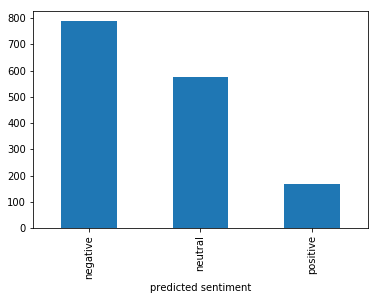

In [289]:
sentences.groupby('predicted sentiment').size().plot(kind='bar')

In [0]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt 

In [0]:
df = sentences[sentences['predicted sentiment']=='negative']

words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

stopwords = set(STOPWORDS)
stopwords.add("AvengersEndgame")
stopwords.add("Avengers")
stopwords.add("Endgame")
stopwords.add("Marvel")
stopwords.add("Studio")
stopwords.add("Avengersâ")

wordcloud = WordCloud(stopwords=stopwords,
                      background_color='grey',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

In [292]:
type(cleaned_word)

str

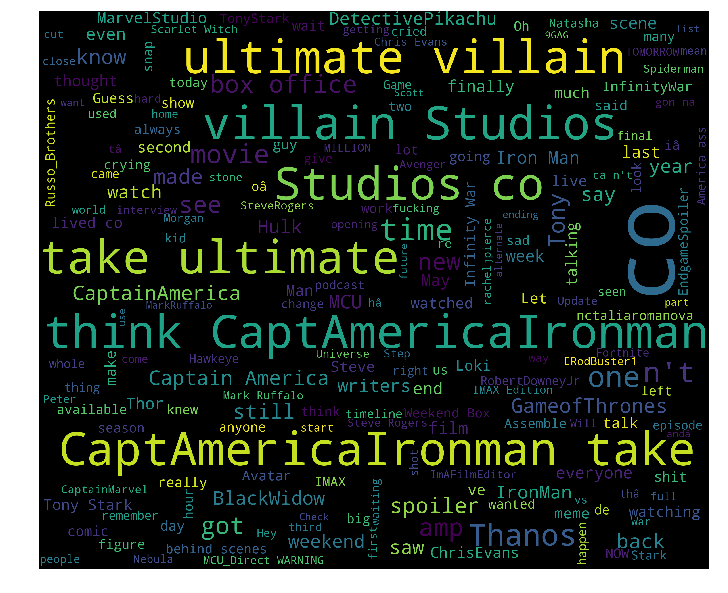

In [293]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [0]:
df = sentences[sentences['predicted sentiment']=='positive']

words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                                and word !='&amp'
                            ])

stopwords = set(STOPWORDS)
stopwords.add("AvengersEndgame")
stopwords.add("Avengers")
stopwords.add("Endgame")
stopwords.add("Marvel")
stopwords.add("Studio")
stopwords.add("Avengersâ")


wordcloud = WordCloud(stopwords=stopwords,
                      background_color='grey',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

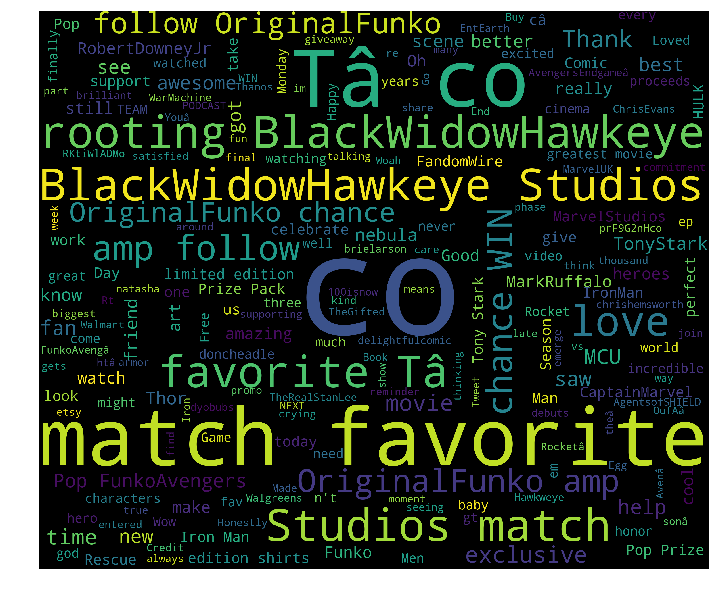

In [295]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()